In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1a39eae0d48>,
 'date': '2010-01-01',
 'id': 1,
 'tobs': 65.0,
 'prcp': 0.08,
 'station': 'USC00519397'}

In [11]:
first_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1a39eafe948>,
 'station': 'USC00519397',
 'latitude': 21.2716,
 'elevation': 3.0,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1,
 'longitude': -157.8168}

In [12]:
max_date= session.query(func.max(Measurement.date)).first()[0]
year_before_max_date =  dt.datetime.strptime(max_date, '%Y-%m-%d') - dt.timedelta(days=365)
print(year_before_max_date)

#from datetime import timedelta
#min_date = max_date - timedelta(days=1)
#min_date

2016-08-23 00:00:00


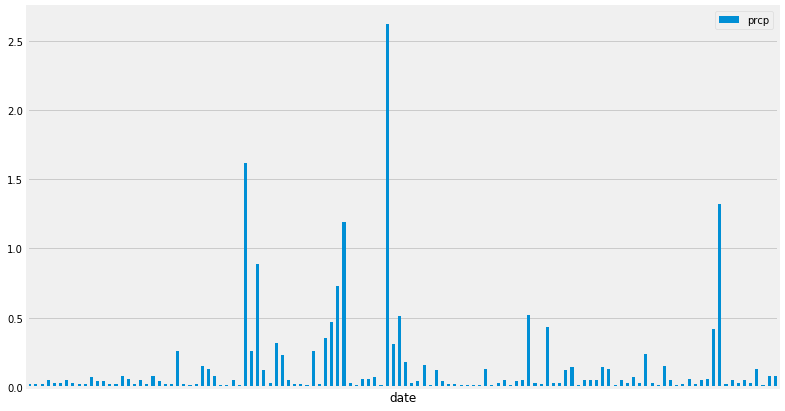

In [95]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database

# Perform a query to retrieve the data and precipitation scores

# Save the query results as a Pandas DataFrame and set the index to the date column

# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_data = []
precipitation_data_all = []
precipitations = session.query(Measurement.prcp,Measurement.date).group_by(Measurement.date).filter(Measurement.date >=year_before_max_date)
precipitations_all = session.query(Measurement.prcp,Measurement.date).group_by(Measurement.date)
for precipitation in precipitations:
    precipitation_data.append(precipitation)
for precipitation in precipitations_all:
    precipitation_data_all.append(precipitation)
precipitation_pd = pd.DataFrame(precipitation_data)
precipitation_all_pd = pd.DataFrame(precipitation_data_all)
precipitation_pd = precipitation_pd.replace(0, np.nan)
precipitation_pd = precipitation_pd.dropna(how='any')
precipitation_all_pd = precipitation_all_pd.dropna(how='any')
precipitation_pd = precipitation_pd.sort_values('date',ascending=False)
precipitation_pd.plot(kind='bar',x='date',y='prcp',figsize=(12,7))
plt.xticks([])
plt.show()


In [17]:
precipitation_all_pd.describe()

,prcp
count,2753.000000
mean,0.053814
std,0.240275
min,0.000000
25%,0.000000
50%,0.000000
75%,0.020000
max,4.940000


#### Use Pandas to calcualte the summary statistics for the precipitation data

![describe](Images/describe.png)

In [18]:
unique_stations = session.query(Measurement.station).group_by(Measurement.station).count()
unique_stations

9

In [12]:
# Design a query to show how many stations are available in this dataset?


[(9)]

In [98]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_counts = session.query(Measurement.station,func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc())
station_counts
for station in station_counts:
     print(station)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [20]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

station_tobs  = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).filter(Measurement.station == 'USC00519281')
for tobs in station_tobs:
    print(tobs)

(54.0, 85.0, 71.66378066378067)


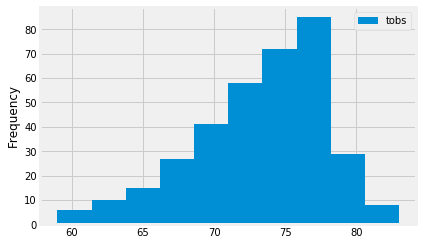

In [27]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs = []
station_tobs  = session.query(Measurement.tobs).filter(Measurement.station == 'USC00519281').filter(Measurement.date >= year_before_max_date)
for tob in station_tobs:
    tobs.append(tob)
tobs_pd = pd.DataFrame(tobs)
tobs_pd.plot.hist()

In [16]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [42]:
def calc_temps_yearago(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
        """
    year_before_start_date =  dt.datetime.strptime(start_date, '%Y-%m-%d') - dt.timedelta(days=365)
    year_before_end_date =  dt.datetime.strptime(end_date, '%Y-%m-%d') - dt.timedelta(days=365)
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= year_before_start_date).filter(Measurement.date <= year_before_end_date).all()

# function usage example
print(calc_temps_yearago('2012-02-28', '2012-03-05'))


[(61.0, 70.17021276595744, 75.0)]


In [17]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


62.0 68.36585365853658 74.0


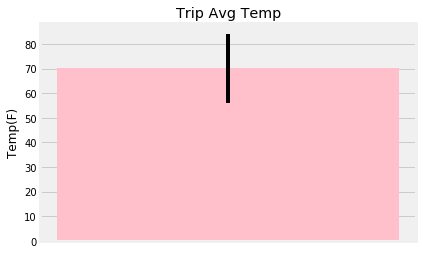

In [94]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip_tmp = (calc_temps_yearago('2012-02-28', '2012-03-05'))
trip_tmp_min = trip_tmp[0][0]
trip_tmp_avg = trip_tmp[0][1]
trip_tmp_max = trip_tmp[0][2]
trip_pd = { "min":trip_tmp_min, "avg": trip_tmp_avg, "max":trip_tmp_max}
trip_df = pd.DataFrame().append(trip_pd, ignore_index=True)
plt.bar(1,trip_df["avg"],color ='pink',yerr = trip_df["max"] - trip_df["min"])
plt.title("Trip Avg Temp")
plt.xticks([])
plt.ylabel("Temp(F)")
plt.show()




In [79]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
rainfall_counts = session.query(Measurement.station,Station.name,Station.latitude,Station.longitude,Station.elevation,func.sum(Measurement.prcp)).filter(Measurement.date >=year_before_max_date).group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc())
for rainfall in rainfall_counts:
    print(rainfall)

('USC00516128', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 1323.9899999999986)
('USC00519281', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 614.1599999999972)
('USC00513117', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 435.23999999999523)
('USC00519523', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 341.9099999999993)
('USC00514830', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 298.71)
('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 144.81000000000117)
('USC00517948', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 41.30999999999996)
